In [3]:
import deepxde as dde
import copy
import numpy as np
from utils import update_collocation, plot_pts, plot_flowfield, eval_pde_loss
from train_PINN import get_NN, train_PINN
from geom_bcs.Lid_Driven import get_liddriven_geom_bcs

dde.config.set_random_seed(42)

def liddriven_pde(x, u):
    nu = 0.0001
    u_vel, v_vel, _ = u[:, [0]], u[:, [1]], u[:, [2]]
    u_vel_x = dde.grad.jacobian(u, x, i=0, j=0)
    u_vel_y = dde.grad.jacobian(u, x, i=0, j=1)
    u_vel_xx = dde.grad.hessian(u, x, component=0, i=0, j=0)
    u_vel_yy = dde.grad.hessian(u, x, component=0, i=1, j=1)

    v_vel_x = dde.grad.jacobian(u, x, i=1, j=0)
    v_vel_y = dde.grad.jacobian(u, x, i=1, j=1)
    v_vel_xx = dde.grad.hessian(u, x, component=1, i=0, j=0)
    v_vel_yy = dde.grad.hessian(u, x, component=1, i=1, j=1)

    p_x = dde.grad.jacobian(u, x, i=2, j=0)
    p_y = dde.grad.jacobian(u, x, i=2, j=1)

    momentum_x = (u_vel * u_vel_x + v_vel * u_vel_y + p_x - nu * (u_vel_xx + u_vel_yy))
    momentum_y = (u_vel * v_vel_x + v_vel * v_vel_y + p_y - nu * (v_vel_xx + v_vel_yy))
    continuity = u_vel_x + v_vel_y

    return [momentum_x, momentum_y, continuity]

geom, bcs = get_liddriven_geom_bcs()
data = dde.data.PDE(geom, liddriven_pde, bcs, num_domain=2000, num_boundary=200, num_test=5000, train_distribution='LHS')

N_adapt_ = 200
compile_kwargs_ = {"optimizer":"adam", "lr":1e-3}
adam_iterations_ = [10000]*3
lbfgs_iterations_ = None
# lbfgs_iterations_ = [0,0,20000]
network_kwars_ = {"layer_size" : [2] + [40] * 5 + [3],
              "activation" : 'tanh',
              "initializer" : 'Glorot uniform'}


Compiling model...
'compile' took 0.000289 s

Training model...

Step      Train loss                                                                Test loss                                                                 Test metric
0         [5.87e-01, 3.10e-01, 1.51e-01, 1.15e+00, 2.46e-01, 8.43e-02, 2.47e-01]    [5.93e-01, 3.13e-01, 1.53e-01, 1.15e+00, 2.46e-01, 8.43e-02, 2.47e-01]    []  
10000     [3.58e-04, 1.80e-05, 3.37e-04, 1.31e-03, 9.23e-06, 5.80e-03, 2.19e-05]    [3.67e-04, 1.63e-05, 1.91e-04, 1.31e-03, 9.23e-06, 5.80e-03, 2.19e-05]    []  

Best model at step 10000:
  train loss: 7.86e-03
  test loss: 7.72e-03
  test metric: []

'train' took 167.193709 s

Though type_adapt is selected as random sampling, but N_adapt!=0 -> N_adapt is manully adjusted to 0!!
Adaptive sampling for type 0 is completed!
Training model...

Step      Train loss                                                                Test loss                                                               

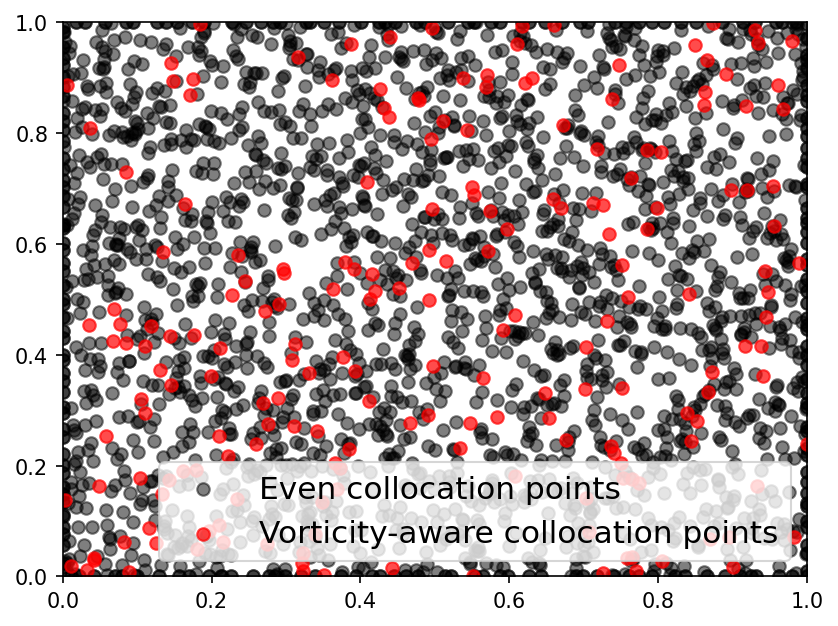

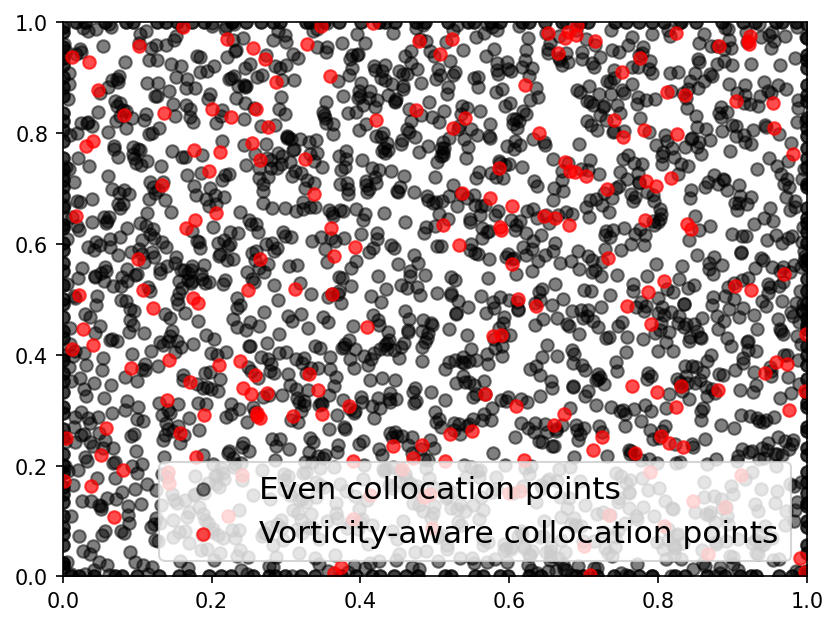

In [5]:
#########################################################################
"""
Vanilla
"""
net = get_NN(**network_kwars_)


PINN_model, data_updated =  train_PINN(net,
                                       data,
                                       compile_kwargs = compile_kwargs_,
                                       adam_iterations=adam_iterations_,
                                       N_adapt=N_adapt_,
                                       type_adapt=0,
                                       lbfgs_iterations=lbfgs_iterations_,
                                       # lbfgs_iterations=[5,5],
                                       save_tag="Van"
                                       )

Compiling model...
'compile' took 0.000314 s

Training model...

Step      Train loss                                                                Test loss                                                                 Test metric
0         [5.24e-02, 5.27e-03, 3.85e-02, 1.89e+00, 8.70e-02, 6.19e-02, 9.90e-02]    [5.27e-02, 5.20e-03, 3.86e-02, 1.89e+00, 8.70e-02, 6.19e-02, 9.90e-02]    []  
10000     [3.77e-04, 2.25e-05, 6.61e-05, 6.76e-04, 1.93e-05, 6.38e-03, 7.13e-06]    [3.17e-04, 2.11e-05, 5.96e-05, 6.76e-04, 1.93e-05, 6.38e-03, 7.13e-06]    []  

Best model at step 10000:
  train loss: 7.54e-03
  test loss: 7.48e-03
  test metric: []

'train' took 170.926366 s

Adaptive sampling for type 1 is completed!
Training model...

Step      Train loss                                                                Test loss                                                                 Test metric
10000     [6.00e-04, 3.56e-05, 1.13e-04, 6.76e-04, 1.93e-05, 6.38e-03, 7.13e-06]    [3.17

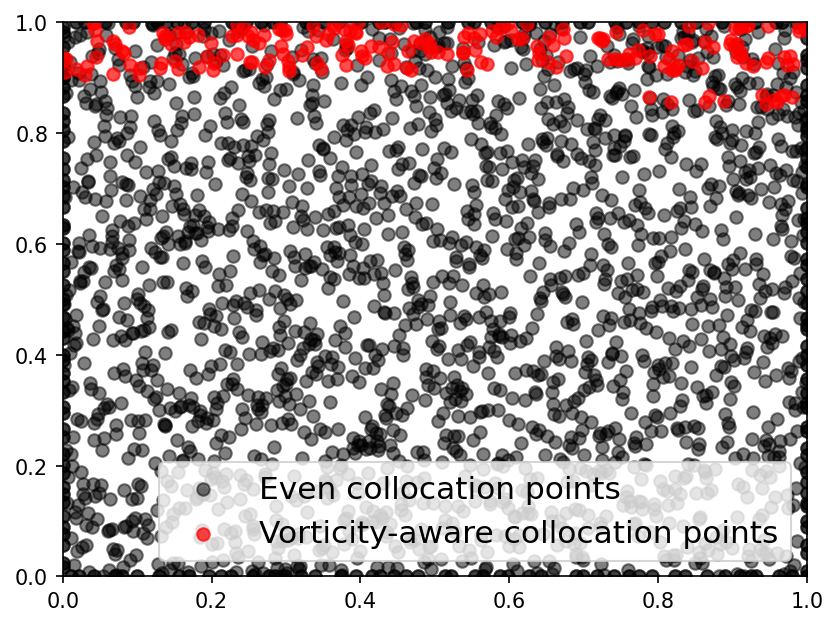

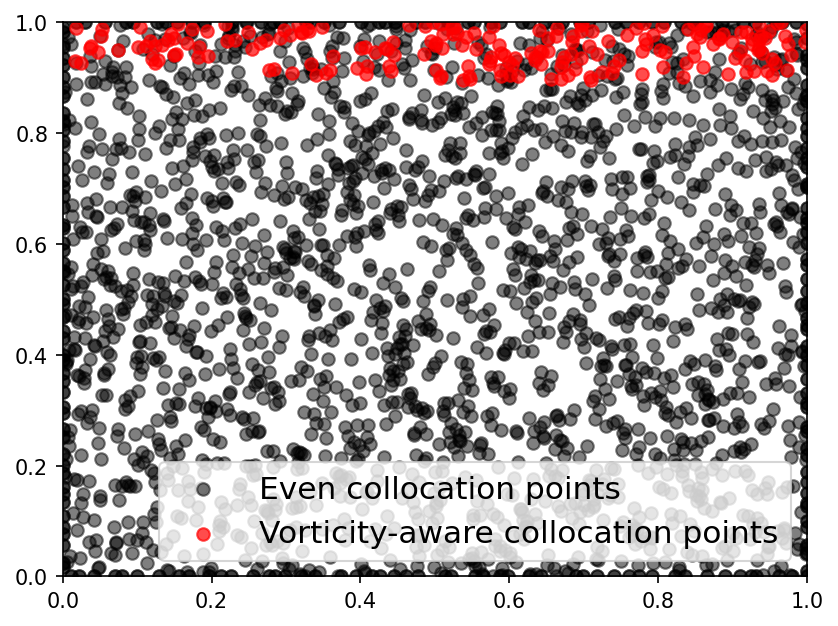

In [17]:
#########################################################################
"""
VA (Vorticity-Aware)
"""
net_VA = get_NN(**network_kwars_)

PINN_model_VA, data_updated =  train_PINN(net_VA,
                                       data,
                                       compile_kwargs = compile_kwargs_,
                                       adam_iterations=adam_iterations_,
                                       N_adapt=N_adapt_,
                                       type_adapt=1,
                                       lbfgs_iterations=lbfgs_iterations_,
                                       # lbfgs_iterations=[5,5],
                                       save_tag="VA"
                                       )


In [ ]:
#########################################################################
"""
PA (advPressure-Aware)
"""
net_PA = get_NN(**network_kwars_)

PINN_model_PA, data_updated =  train_PINN(net_PA,
                                       data,
                                       compile_kwargs = compile_kwargs_,
                                       adam_iterations=adam_iterations_,
                                       N_adapt=N_adapt_,
                                       type_adapt=2,
                                       lbfgs_iterations=lbfgs_iterations_,
                                       # lbfgs_iterations=[5,5],
                                       save_tag="PA"
                                       )


Compiling model...
'compile' took 0.000179 s

Training model...

Step      Train loss                                                                Test loss                                                                 Test metric
0         [5.26e-03, 1.05e-02, 7.03e-02, 7.25e-01, 2.90e-02, 2.15e-02, 1.90e-02]    [5.23e-03, 1.07e-02, 6.94e-02, 7.25e-01, 2.90e-02, 2.15e-02, 1.90e-02]    []  
10000     [2.91e-04, 3.21e-05, 6.48e-05, 5.57e-04, 1.17e-05, 5.74e-03, 5.70e-06]    [2.78e-04, 4.07e-05, 4.80e-05, 5.57e-04, 1.17e-05, 5.74e-03, 5.70e-06]    []  

Best model at step 10000:
  train loss: 6.70e-03
  test loss: 6.68e-03
  test metric: []

'train' took 170.485057 s

Adaptive sampling for type 3 is completed!
Training model...

Step      Train loss                                                                Test loss                                                                 Test metric
10000     [4.69e-04, 5.55e-05, 8.61e-05, 5.57e-04, 1.17e-05, 5.74e-03, 5.70e-06]    [2.78

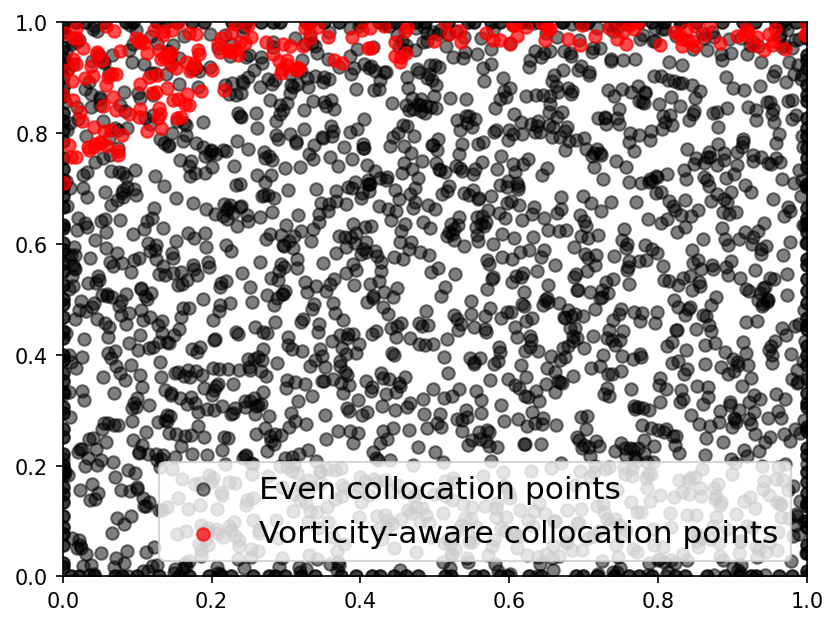

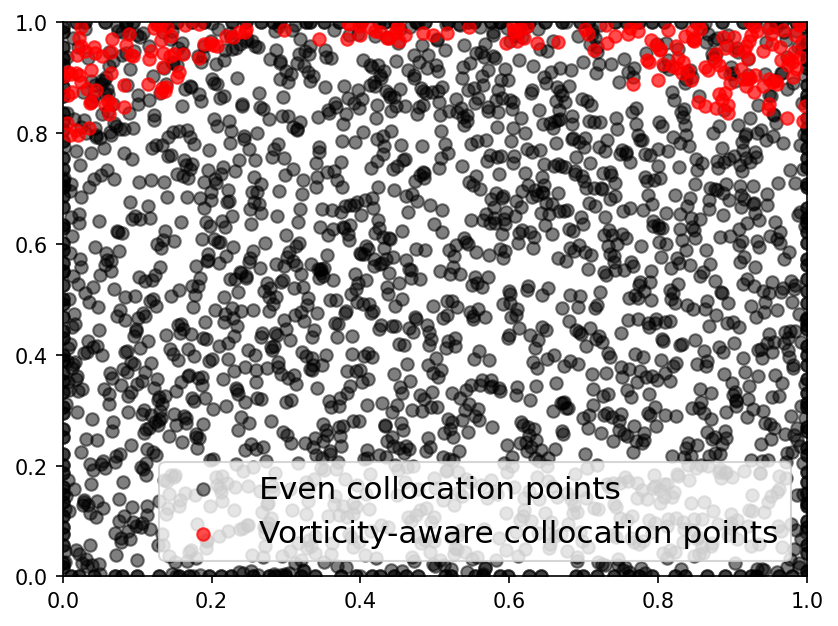

In [15]:
#########################################################################
"""
VPA (Vorticity-advP-Aware)
"""
net_VPA = get_NN(**network_kwars_)

PINN_model_VPA, data_updated =  train_PINN(net_VPA,
                                       data,
                                       compile_kwargs = compile_kwargs_,
                                       adam_iterations=adam_iterations_,
                                       N_adapt=N_adapt_,
                                       type_adapt=3,
                                       lbfgs_iterations=lbfgs_iterations_,
                                       # lbfgs_iterations=[5,5],
                                       save_tag="VPA"
                                       )



Compiling model...
'compile' took 0.000308 s

Training model...

0         [4.33e-02, 1.74e-03, 2.07e-01, 1.07e+00, 4.37e-02, 2.04e-02, 1.01e-02]    [4.33e-02, 1.60e-03, 2.08e-01, 1.07e+00, 4.37e-02, 2.04e-02, 1.01e-02]    []  
10000     [5.10e-04, 3.63e-05, 1.25e-04, 4.56e-03, 1.48e-05, 6.49e-03, 2.55e-05]    [1.25e-04, 3.16e-05, 6.60e-05, 4.56e-03, 1.48e-05, 6.49e-03, 2.55e-05]    []  

Best model at step 10000:
  train loss: 1.18e-02
  test loss: 1.13e-02
  test metric: []

'train' took 167.845255 s

Adaptive sampling for type 4 is completed!
Training model...

Step      Train loss                                                                Test loss                                                                 Test metric
10000     [3.12e-04, 5.52e-05, 1.39e-04, 4.56e-03, 1.48e-05, 6.49e-03, 2.55e-05]    [1.25e-04, 3.16e-05, 6.60e-05, 4.56e-03, 1.48e-05, 6.49e-03, 2.55e-05]    []  
20000     [3.48e-04, 3.79e-05, 5.34e-05, 4.61e-04, 5.13e-05, 4.51e-03, 1.46e-05]    [1.99e-04, 2

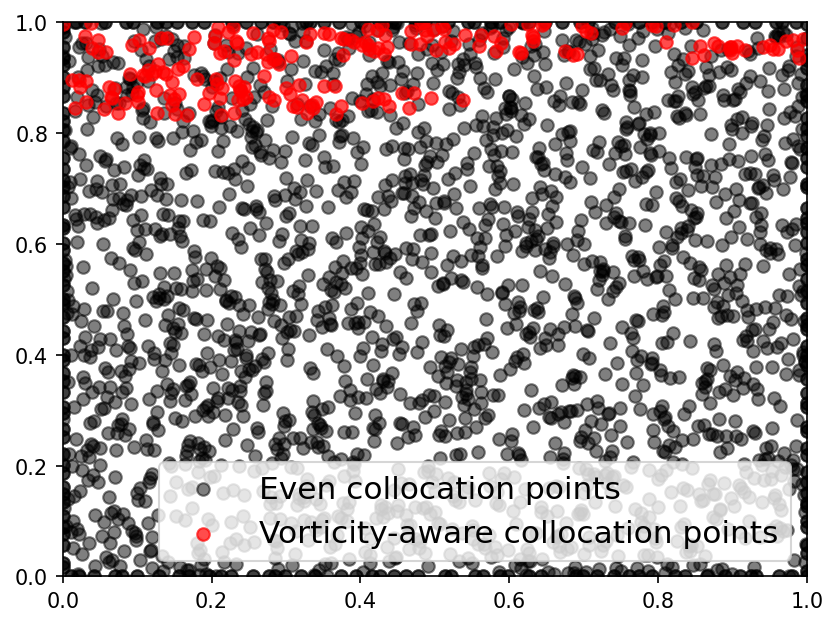

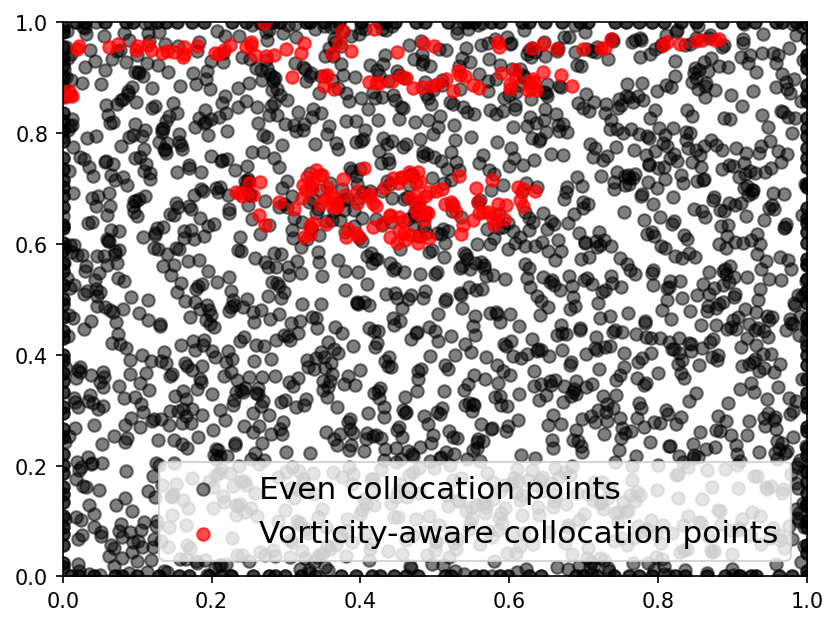

In [7]:
#########################################################################
"""
RA (residual-aware)
"""
net_RA = get_NN(**network_kwars_)

PINN_model_RA, data_updated =  train_PINN(net_RA,
                                       data,
                                       compile_kwargs = compile_kwargs_,
                                       adam_iterations=adam_iterations_,
                                       N_adapt=N_adapt_,
                                       type_adapt=4,
                                       lbfgs_iterations=lbfgs_iterations_,
                                       # lbfgs_iterations=[5,5],
                                       save_tag="RA"
                                       )



Compiling model...
'compile' took 0.000256 s

Training model...

Step      Train loss                                                                Test loss                                                                 Test metric
0         [1.64e-02, 1.21e-02, 1.06e-01, 1.96e+00, 1.65e-02, 7.74e-02, 1.16e-02]    [1.55e-02, 1.23e-02, 1.06e-01, 1.96e+00, 1.65e-02, 7.74e-02, 1.16e-02]    []  
10000     [7.06e-04, 8.24e-04, 1.85e-04, 3.88e-03, 8.42e-06, 5.24e-03, 1.25e-05]    [3.28e-04, 4.19e-04, 1.56e-04, 3.88e-03, 8.42e-06, 5.24e-03, 1.25e-05]    []  

Best model at step 10000:
  train loss: 1.09e-02
  test loss: 1.00e-02
  test metric: []

'train' took 167.844459 s

Adaptive sampling for type 5 is completed!
Training model...

Step      Train loss                                                                Test loss                                                                 Test metric
10000     [8.41e-04, 8.65e-04, 2.66e-04, 3.88e-03, 8.42e-06, 5.24e-03, 1.25e-05]    [3.28

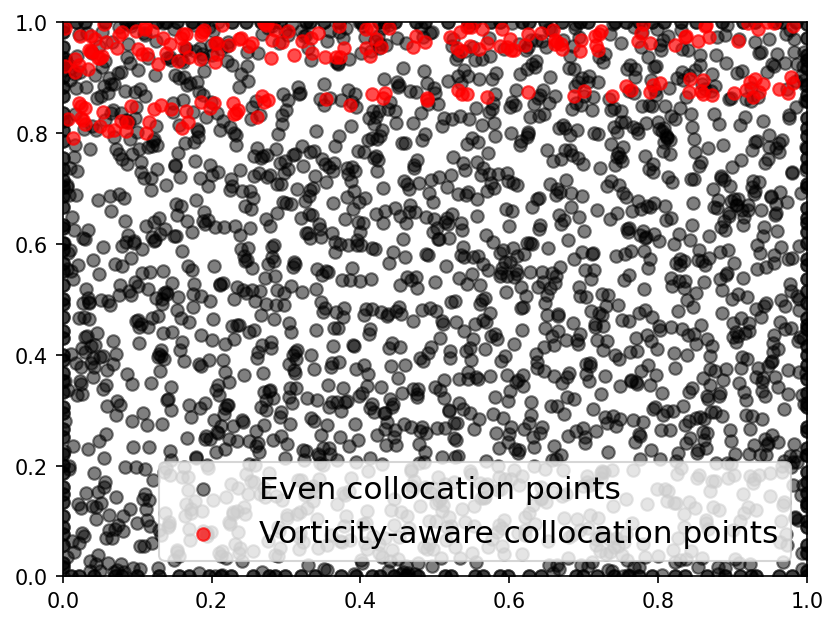

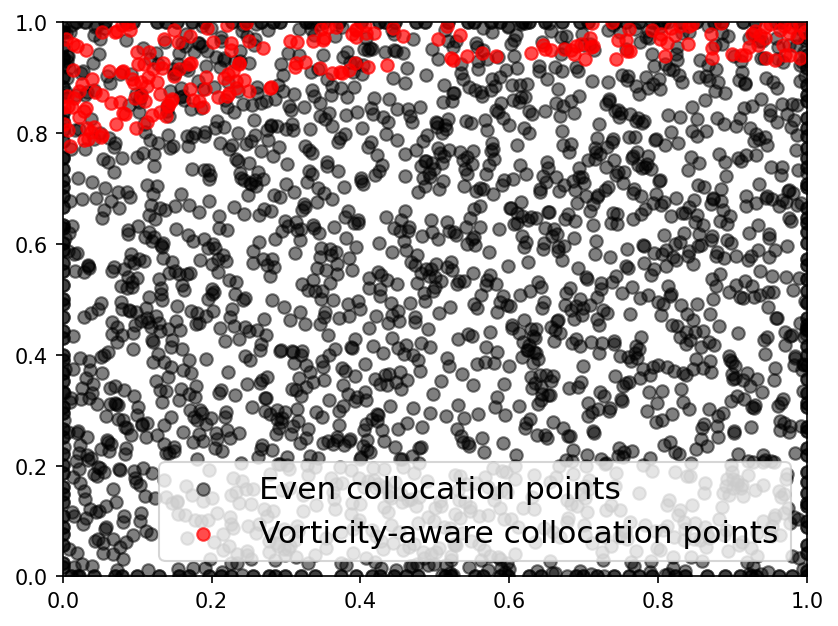

In [8]:
#########################################################################
"""
GA (gradient-aware)
"""
net_GA = get_NN(**network_kwars_)

PINN_model_GA, data_updated =  train_PINN(net_GA,
                                       data,
                                       compile_kwargs = compile_kwargs_,
                                       adam_iterations=adam_iterations_,
                                       N_adapt=N_adapt_,
                                       type_adapt=5,
                                       lbfgs_iterations=lbfgs_iterations_,
                                       # lbfgs_iterations=[5,5],
                                       save_tag="GA"
                                       )



**** Vanilla test losses ****
tensor([2.7856e-03, 6.2486e-05, 5.6786e-05, 9.9803e-01, 5.8285e-06, 7.3245e-07,
        5.8149e-06])
**** VA test losses ****
tensor([3.9614e-04, 7.5149e-05, 4.9524e-05, 9.9778e-01, 7.5325e-07, 1.2374e-06,
        9.0417e-07])
**** PA test losses ****
tensor([5.3289e-04, 1.9459e-05, 3.6841e-05, 9.9887e-01, 4.8062e-06, 1.0394e-06,
        6.3037e-06])
**** VPA test losses ****
tensor([9.2461e-04, 1.7443e-04, 3.9323e-05, 9.9932e-01, 4.6700e-06, 1.4982e-07,
        6.5573e-06])


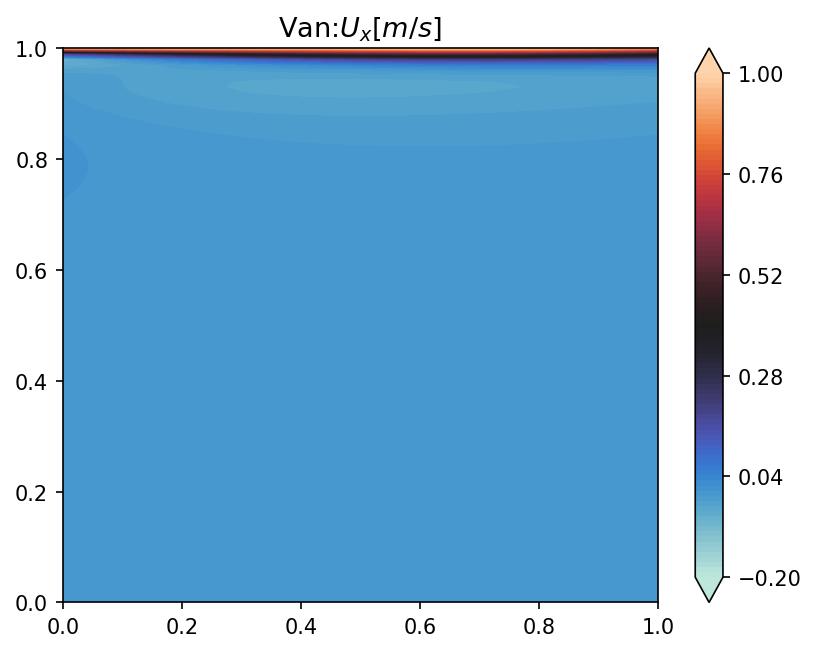

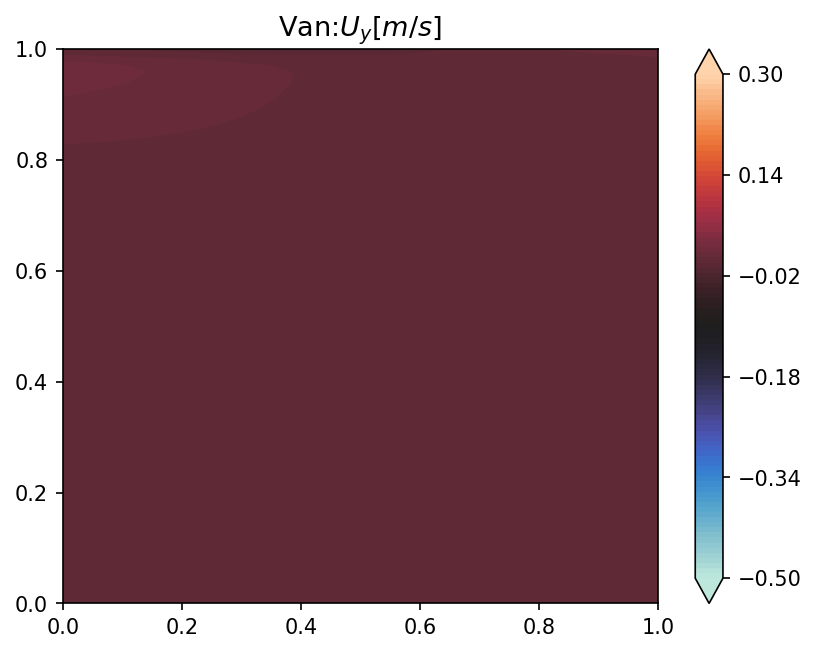

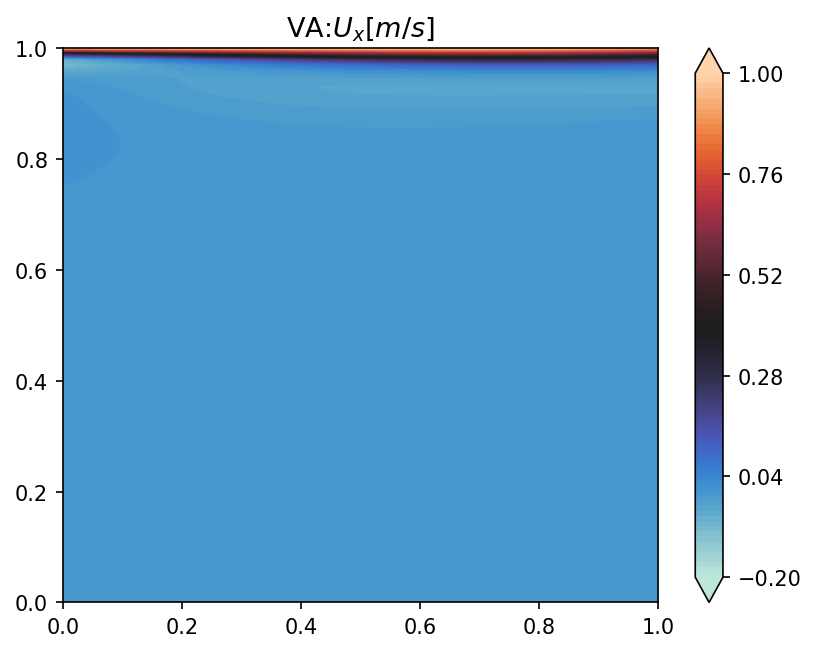

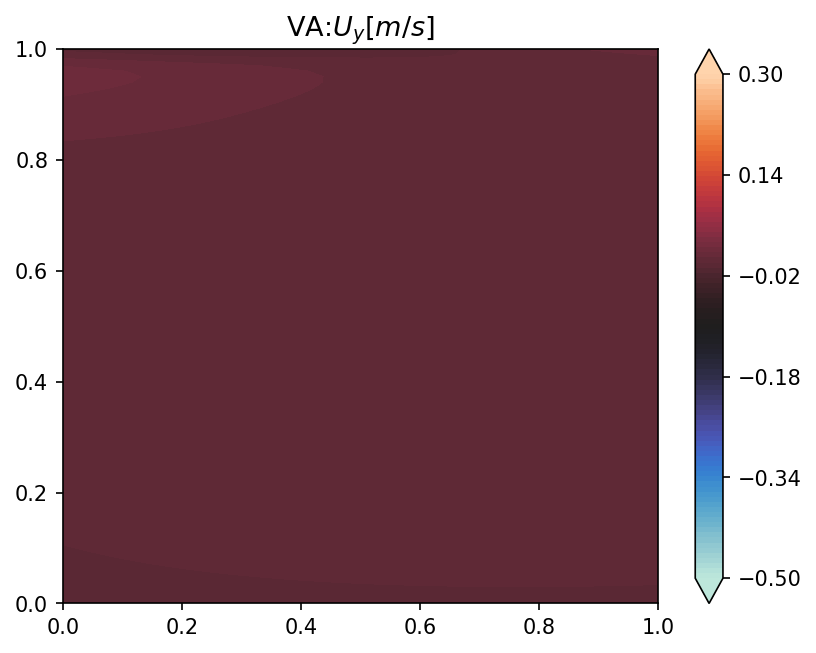

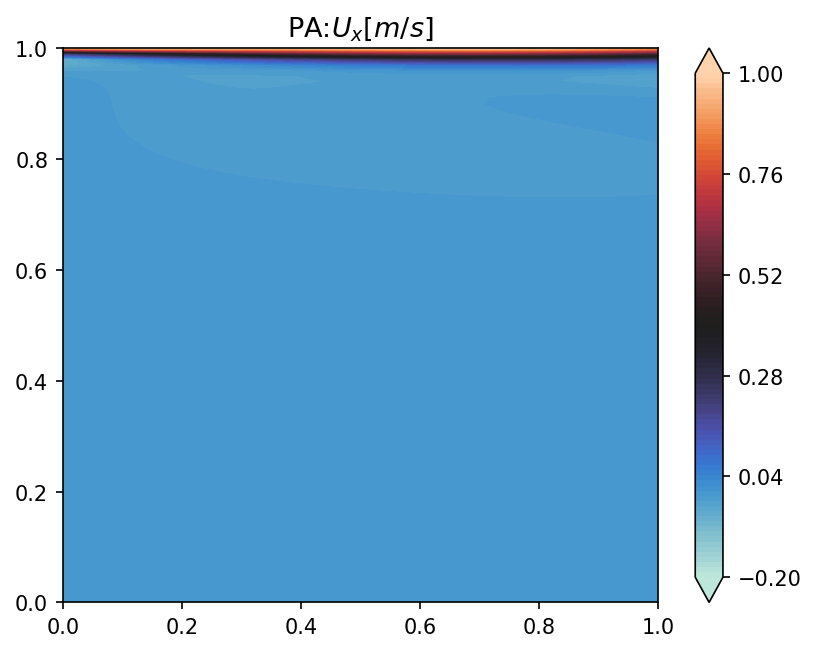

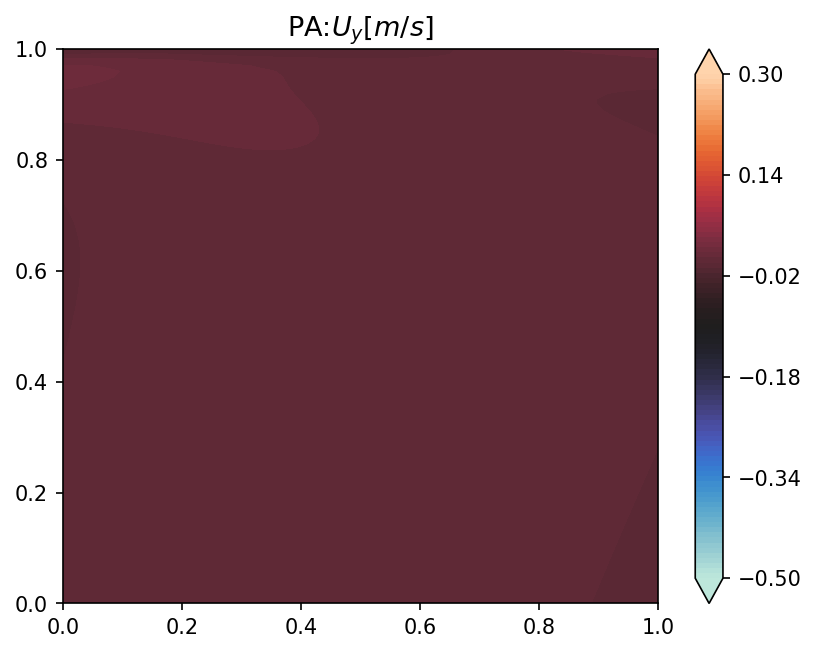

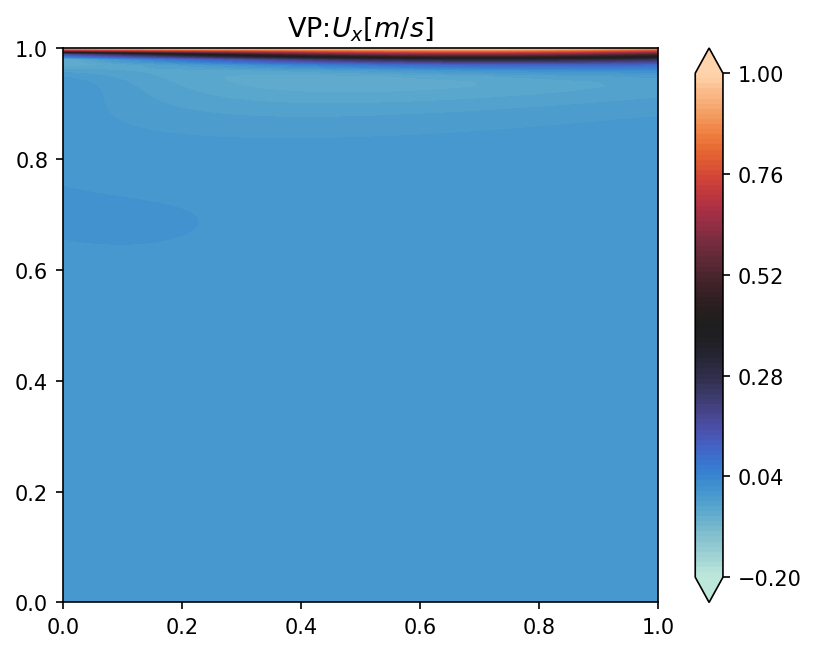

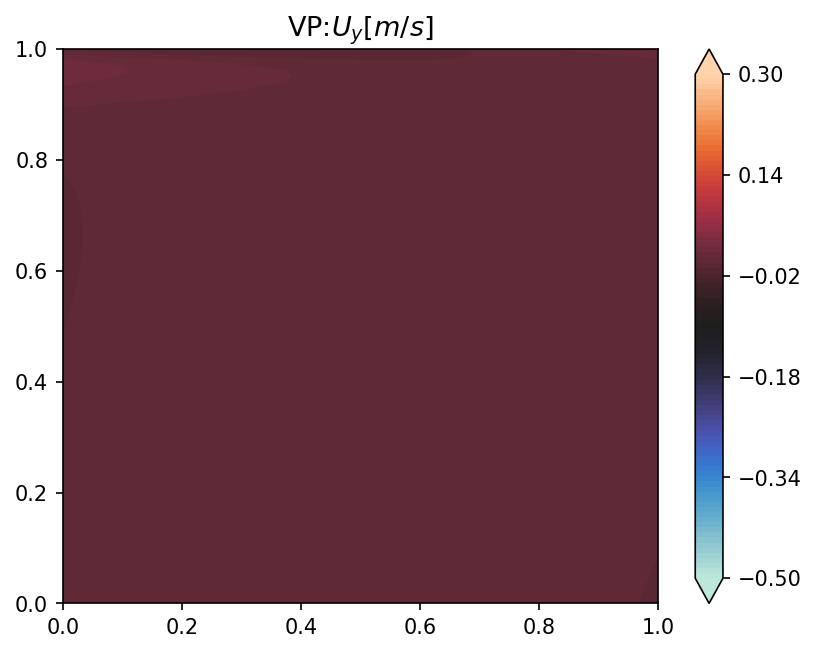

In [19]:
########################### Draw flowfield ###########################

x1_test = np.linspace(0, 1, 101)
x2_test = np.linspace(0, 1, 101)
X_test = np.zeros((len(x1_test)*len(x2_test), 2))
X_test[:, 0] = np.vstack((x1_test,)*len(x2_test)).reshape(-1)
X_test[:, 1] = np.vstack((x2_test,)*len(x1_test)).T.reshape(-1)

Y_test = PINN_model.predict(X_test)
Y_test_VA = PINN_model_VA.predict(X_test)
Y_test_PA = PINN_model_PA.predict(X_test)
Y_test_VPA = PINN_model_VPA.predict(X_test)

plot_flowfield(x1=x1_test, x2=x2_test, y1=Y_test[:,0], y2=Y_test[:,1], tag='Van', stream=False)
plot_flowfield(x1=x1_test, x2=x2_test, y1=Y_test_VA[:,0], y2=Y_test_VA[:,1], tag='VA', stream=False)
plot_flowfield(x1=x1_test, x2=x2_test, y1=Y_test_PA[:,0], y2=Y_test_PA[:,1], tag='PA', stream=False)
plot_flowfield(x1=x1_test, x2=x2_test, y1=Y_test_VPA[:,0], y2=Y_test_VPA[:,1], tag='VP', stream=False)


print("**** Vanilla test losses ****")
print(eval_pde_loss(PINN_model))
print("**** VA test losses ****")
print(eval_pde_loss(PINN_model_VA))
print("**** PA test losses ****")
print(eval_pde_loss(PINN_model_PA))
print("**** VPA test losses ****")
print(eval_pde_loss(PINN_model_VPA))

In [14]:
asdf = PINN_model.predict(X_test, operator=data.pde)
print(asdf[0].shape)

(10201, 1)
